<a href="https://colab.research.google.com/github/kaseyriver11/canoe-detection/blob/main/canoe_detection_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pycocotools
! pip install torchvision==0.11.3

In [3]:
# Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import pycocotools
os.chdir("/content/drive/MyDrive/canoes")

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git

In [6]:
%%bash
cd vision
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

In [7]:
# Import Everything
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from pathlib import Path
from PIL import ImageDraw

In [8]:
def parse_one_annot(boxes_df, filename):
   boxes_array = boxes_df[boxes_df["filename"] == filename][["xmin", "ymin", "xmax", "ymax"]].values
   
   return boxes_array

In [9]:
# Create a custom dataset class for the canoe data
class CanoeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
       self.path_root = Path(root)
       self.transforms = transforms
       self.imgs = sorted([i for i in os.listdir(os.path.join(root, "images")) if '.jpg' in i])
       self.boxes_df = pd.read_csv(self.path_root.joinpath("boxes.csv"))

    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = self.path_root.joinpath("images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.boxes_df, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)

        num_objs = len(box_list)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd ( we are not doing segmentation)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
            return len(self.imgs)


In [ ]:
cd = CanoeDataset(root="")
cd[0]

In [16]:
import torchvision
def get_model(num_classes):
   # load an object detection model pre-trained on COCO
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   # get the number of input features for the classifier
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
   return model

In [17]:
def get_transform(train):
   transforms = []
   # converts the image, a PIL image, into a PyTorch Tensor
   transforms.append(T.ToTensor())
   if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [18]:
# use our dataset and defined transformations
dataset = CanoeDataset(root="", transforms = get_transform(train=True))
dataset_test = CanoeDataset(root="", transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 161 examples, 121 are training and 40 testing


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
torch.cuda.is_available()

True

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# our dataset has two classes only: Canoe and Not Canoe
num_classes = 2

model = get_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

## Save the Model

In [24]:
import torch
model_dir = cd.path_root.joinpath("model/")

In [ ]:
model_dir.mkdir(exist_ok=True)
torch.save(model.state_dict(), model_dir.joinpath("canoe_model"))

## Load the Model

In [31]:
# Load model and put in eval mode
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(model_dir.joinpath("canoe_model")))
loaded_model.eval()
""

''

## Show a few examples

In [39]:
def draw_image(idx: int):
  img, _ = dataset_test[idx]
  label_boxes = np.array(dataset_test[idx][1]["boxes"])

  with torch.no_grad():
      prediction = loaded_model([img])

  image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  draw = ImageDraw.Draw(image)

  # Draw the Ground Truth in Green
  for elem in range(len(label_boxes)):
      draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
                      (label_boxes[elem][2], label_boxes[elem][3])],
                    outline="green", width=3)

  # Draw the Predictions in Red if prediction > .8
  for element in range(len(prediction[0]["boxes"])):
      boxes = prediction[0]["boxes"][element].cpu().numpy()
      score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals=4)
      if score > 0.8:
          draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="red", width=3)
          draw.text((boxes[0], boxes[1]), text=str(score))
  return image.resize([500, 500])

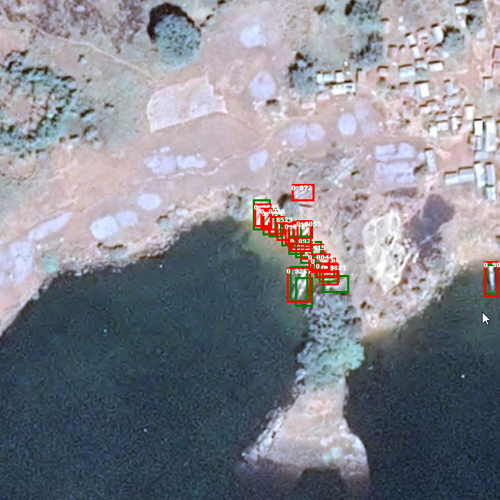

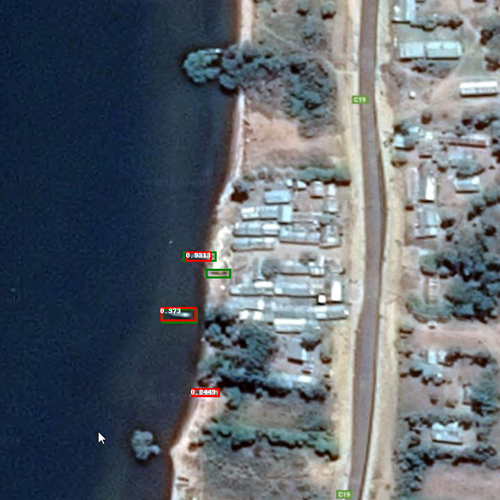

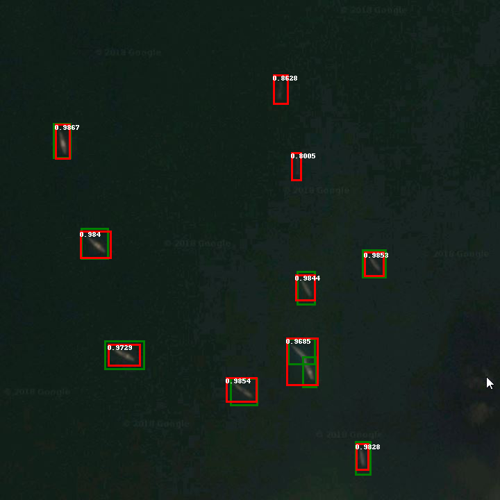

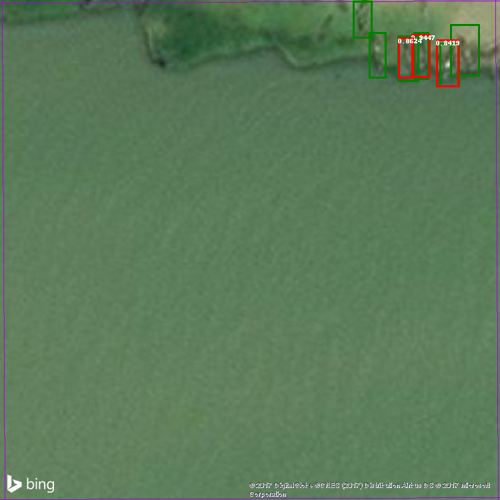

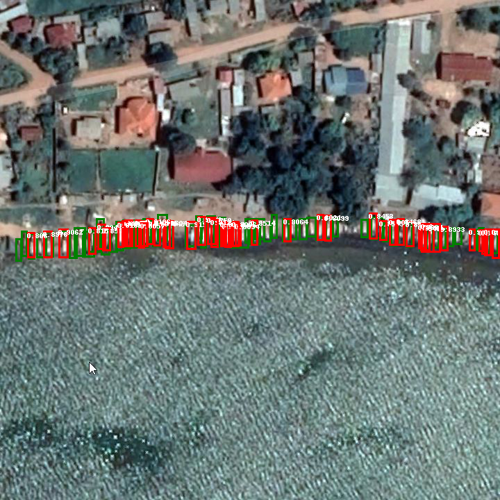

In [45]:
for i in range(0, 5):
    display(draw_image(i))

## Compare Actual Counts and Predicted Counts

In [70]:
from tqdm import tqdm

In [77]:
results = []

for idx in tqdm(range(len(dataset_test))):
  img, info = dataset_test[idx]
  name = dataset_test.dataset.imgs[i]
  labeled_count = len(info['boxes'])

  with torch.no_grad():
      prediction = loaded_model([img])

  pred_boxes_7 = len([i for i in prediction[0]['scores'] if i > .7])
  pred_boxes_8 = len([i for i in prediction[0]['scores'] if i > .8])
  pred_boxes_9 = len([i for i in prediction[0]['scores'] if i > .9])

  results.append([name, labeled_count, pred_boxes_7, pred_boxes_8, pred_boxes_9])

100%|██████████| 40/40 [03:19<00:00,  4.99s/it]


In [78]:
results_df = pd.DataFrame(results, columns = ['Image', 'Labeled_Count', "Pred_70", "Pred_80", "Pred_90"])

In [80]:
abs(results_df['Labeled_Count'] - results_df['Pred_70']).mean()

4.725

In [81]:
results_df

,Image,Labeled_Count,Pred_70,Pred_80,Pred_90
0,2018-04-15 17_48_07-Lake Victoria.jpg,16,19,17,7
1,2018-04-15 17_48_07-Lake Victoria.jpg,3,3,3,2
2,2018-04-15 17_48_07-Lake Victoria.jpg,9,10,10,8
3,2018-04-15 17_48_07-Lake Victoria.jpg,6,5,3,1
4,2018-04-15 17_48_07-Lake Victoria.jpg,60,76,44,9
5,2018-04-15 17_48_07-Lake Victoria.jpg,3,2,2,1
6,2018-04-15 17_48_07-Lake Victoria.jpg,1,1,1,1
7,2018-04-15 17_48_07-Lake Victoria.jpg,1,1,1,1
8,2018-04-15 17_48_07-Lake Victoria.jpg,5,4,4,2
9,2018-04-15 17_48_07-Lake Victoria.jpg,2,3,3,2


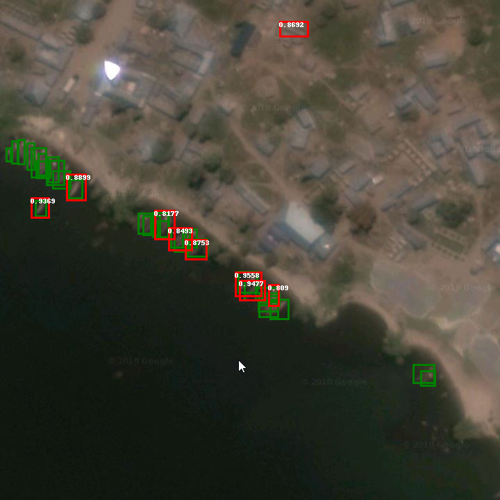

In [76]:
display(draw_image(38))